In [135]:
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
import numpy as np

# some constants
X_LABEL = "Number of days since index case (12 Jan 2020)"
Y_LABEL = "Number of infected cases (millions)"

# Loading the data

This step is pretty simple. This notebook simply loads the data that we have obtained from the open
data sets from the Thai government. Only the files have been renamed, but the contain remains the same.

Once the data is loaded, we change the index of the DataFrame into the number of days since $t_0$, 
which is 12 Jan 2020 which was when the first case of COVID-19 was spotted in Thailand.

In [136]:
infections_df = pd.concat([
    pd.read_csv("data/report_data01.csv"),
    pd.read_csv("data/report_data02.csv"),
    pd.read_csv("data/report_data03.csv")
])
infections_df["infected"] = 1
infections_df.shape  # that's a lot of data :o

/var/folders/0g/n7mxhq7n7jl82nyrqxqkdp780000gn/T/ipykernel_88083/3873676791.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv("data/report_data01.csv"),


(1907755, 12)

In [137]:
def transform_date(date_str: str):
    d, m, y = map(int, date_str.split('/'))
    return date(y, m, d)

infections_df["announce_date"] = infections_df["announce_date"].map(transform_date)

In [138]:
timedelta_infections = infections_df.groupby("announce_date").count().sort_index()["infected"]

t0 = timedelta_infections.index[0]
timedelta_infections.index = timedelta_infections.index.map(lambda cidx: (cidx - t0).days)

# First look at the data

Following is the scatterplot of the number of infections as time goes on.

Also notice that for `ys`, we divide the total by one million to ensure that Python does not scream at us about floating point numbers being too large.

In [139]:
xs = timedelta_infections.index.to_numpy()
ys = np.cumsum(timedelta_infections.to_numpy()) / 1e6

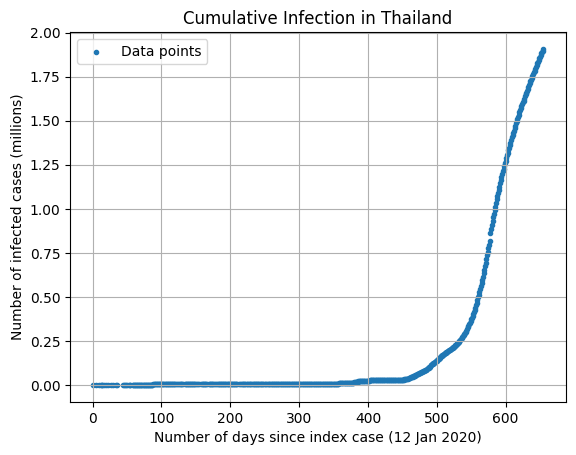

In [140]:
plt.scatter(xs, ys, label="Data points", marker=".")
plt.title("Cumulative Infection in Thailand")
plt.xlabel(X_LABEL)
plt.ylabel(Y_LABEL)
plt.grid()
plt.legend()

# Fitting a Logistic Model based on Differential Equations

Recall the differential equation for logistic growth.
$$ \frac{dy}{dt} = ry\left(1 - \frac{y}{K}\right) $$
where
- $y$ is the current population
- $r$ is the growth rate
- $K$ is the maximum carrying capacity
we want to fit a model that will represent the data set that we have on hand.

Since our transformed data set contains over 600 data points
~~and the human who wrote up this notebook is a CS human so they're very lazy~~,
we are going to use the *power of technology* to help us fit the model.

In [141]:
from scipy.integrate import odeint

r0 = 0.025
K0 = 2.5
y0 = np.array([1e-6])

def dydt(t, y, r, K):
    return r * y * (1 - y / K)
soln = odeint(dydt, y0=y0, t=xs, args=(r0, K0), tfirst=True)

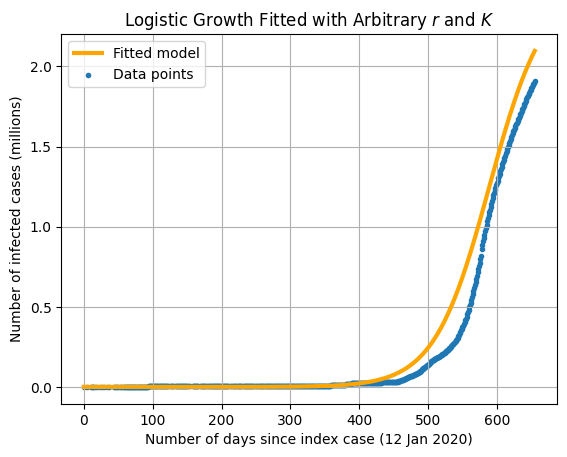

In [142]:
plt.plot(xs, soln, label="Fitted model", color="orange", linewidth=3)
plt.scatter(xs, ys, label="Data points", marker=".")
plt.title("Logistic Growth Fitted with Arbitrary $r$ and $K$")
plt.xlabel(X_LABEL)
plt.ylabel(Y_LABEL)
plt.legend()
plt.grid()

## Optimizing Results

Notice from the plot above that we our random guess for $r$ seems to be going somewhere. However,
*this is not as good as it gets*. As Dr. Sunsern Cheamanunkul always say in the Algorithms class,
"***We can always do better***."

In [143]:
from scipy.optimize import minimize
from scipy.integrate import solve_ivp

def to_minimize(v):
    r, K = v
    current_soln = odeint(dydt, y0=y0, t=xs, args=(r, K), tfirst=True)
    return np.sum((ys - current_soln[:, 0]) ** 2)

opt_soln = minimize(to_minimize, [r0, K0], method="Nelder-Mead")
c_soln = solve_ivp(dydt, y0=y0, t_span=(0, max(xs)), args=opt_soln.x, dense_output=True)
opt_soln

 final_simplex: (array([[0.02417666, 2.74352873],
       [0.02417661, 2.74360359],
       [0.02417665, 2.74358182]]), array([1.06900755, 1.06900755, 1.06900755]))
           fun: 1.0690075473581357
       message: 'Optimization terminated successfully.'
          nfev: 67
           nit: 35
        status: 0
       success: True
             x: array([0.02417666, 2.74352873])

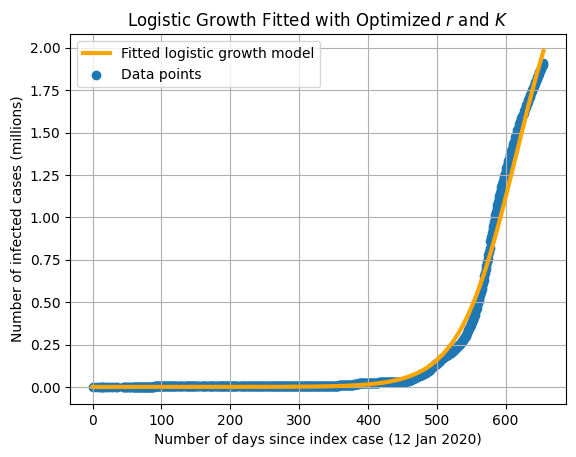

In [144]:
plt.plot(xs, c_soln.sol(xs).T, label="Fitted logistic growth model", color="orange", linewidth=3)
plt.scatter(xs, ys, label="Data points")
plt.title("Logistic Growth Fitted with Optimized $r$ and $K$")
plt.xlabel(X_LABEL)
plt.ylabel(Y_LABEL)
plt.legend()
plt.grid()

In [145]:

days_to_consider = (date(2023, 12, 31) - t0).days
nts = np.linspace(0, days_to_consider, 1000)
c_soln = solve_ivp(dydt, y0=y0, t_span=(0, max(nts)), args=opt_soln.x, dense_output=True)

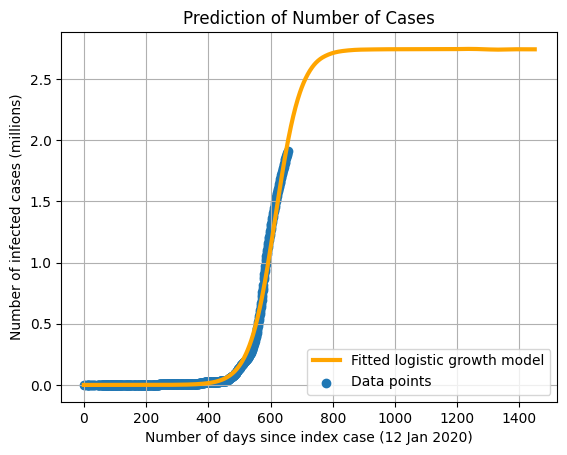

In [146]:
plt.plot(nts, c_soln.sol(nts).T, label="Fitted logistic growth model", color="orange", linewidth=3)
plt.scatter(xs, ys, label="Data points")
plt.title("Prediction of Number of Cases")
plt.xlabel(X_LABEL)
plt.ylabel(Y_LABEL)
plt.legend()
plt.grid()

# Conclusion

Therefore, our logistic growth function would become approximately
$$ \frac{dy}{dt} = 0.02417666y\left(1 - \frac{y}{2.74352873}\right) $$
Also, do note that the unit is a million cases, not cases by itself.

## Observations

From the prediction plot, we can see that the infection cases will start to plateau around $t = 800$,
which is around March 2022. This also coincides with MUIC's COVID policy where on-site classes started
to take place again around T3/2021 which started in April 2022. However, if we had more recent data,
specifically from 2022, we might be able to make a better model for the rate at which the cases go up.

In [148]:
from datetime import timedelta
t0 + timedelta(800)

datetime.date(2022, 3, 22)